In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_datasets as tfds


import sys
sys.path.append('/data/codes/ma-fl-mia/')
from src import attacks, data_preparation, flower_client, models, utils

import os

rng = tf.random.Generator.from_seed(24)


In [2]:

train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)

In [7]:
n_attacker_train = 100
n_attacker_test = 5000

r = data_preparation.get_mia_datasets(train_ds, test_ds,
                                      n_attacker_train,
                                      n_attacker_test)

In [5]:
unit_size = 32
model = models.get_model(unit_size=unit_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                      

In [9]:
unit_size = 32
# Define some hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50

model = models.get_model(unit_size)

# Generate loss and optim
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=["accuracy"])

# Train the model
history = model.fit(train_ds.batch(batch_size),
                    epochs=num_epochs,
                    validation_data=test_ds.batch(batch_size))

Epoch 1/50
1563/1563 [==============================] - 19s 11ms/step - loss: 1.2711 - accuracy: 0.5495 - val_loss: 1.1495 - val_accuracy: 0.6013
Epoch 2/50
1563/1563 [==============================] - 18s 11ms/step - loss: 0.8619 - accuracy: 0.6985 - val_loss: 0.9171 - val_accuracy: 0.6821
Epoch 3/50
1563/1563 [==============================] - 17s 11ms/step - loss: 0.7070 - accuracy: 0.7548 - val_loss: 0.8123 - val_accuracy: 0.7257
Epoch 4/50
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6024 - accuracy: 0.7906 - val_loss: 0.8241 - val_accuracy: 0.7304
Epoch 5/50
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5162 - accuracy: 0.8214 - val_loss: 0.8420 - val_accuracy: 0.7337
Epoch 6/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.4349 - accuracy: 0.8487 - val_loss: 0.8625 - val_accuracy: 0.7381
Epoch 7/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3718 - accuracy: 0.8702 - val_loss: 0.8667 - 

In [21]:
loss_train_attacker, acc_train_attacker = model.evaluate(*r['attacker_knowledge'])
print(loss_train_attacker, acc_train_attacker)

4/4 [==============================] - 0s 6ms/step - loss: 0.1254 - accuracy: 0.9300
0.12537308037281036 0.9300000071525574


In [20]:
losses = utils.predict_losses(model, *r['mia_data'], models.get_loss(), verbose=1)

10000/10000 [==============================] - 31s 3ms/step


100%|██████████| 10000/10000 [00:25<00:00, 391.93it/s]


In [25]:
a = attacks.yeom_mi_attack(np.array(losses), loss_train_attacker)

In [28]:
len(a[a==r['mia_labels']])

6077

In [30]:
advantage = 2*(len(a[a==r['mia_labels']])-len(a)/2)/len(a)*100
advantage

21.54

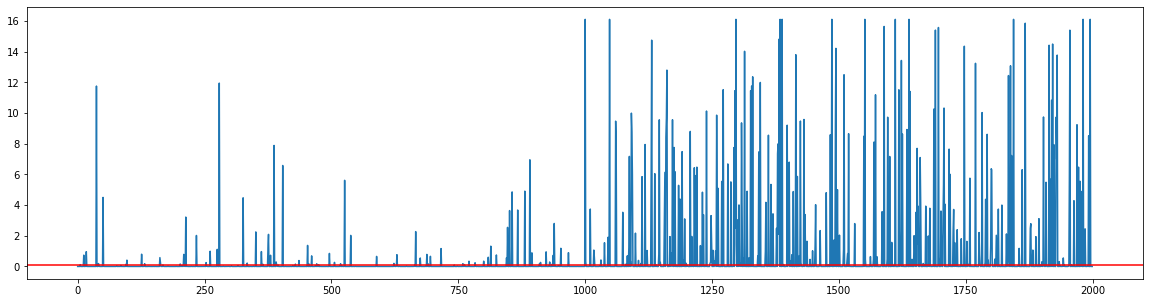

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(losses[1::5])
plt.axhline(y=loss_train_attacker, c="red")

In [32]:
if False:
    try:
        len(stats)
    except:
        stats = []
    stats.append({"val_acc":history.history['val_accuracy'][-1], "Adv_std":advantage, "unit_size":unit_size, "params":model.count_params()})
    stats

## Federated split

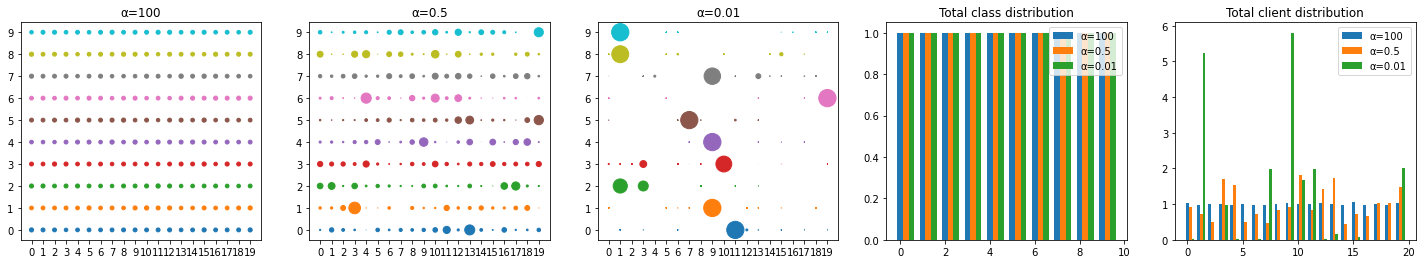

In [36]:
num_classes = 10
num_clients = 20

a_values = [100,0.5,0.01]
fig, axs = plt.subplots(1,len(a_values)+2, figsize=(25,4))
for i in range(len(a_values)):
    s = data_preparation.dirichlet_split(num_classes, num_clients, a_values[i], mode="clients")
    for j, classes in enumerate(s):
        x = list(range(len(classes)))
        y = [j] * len(classes)
        axs[i].scatter(x, y, s=300*classes)
    axs[i].set_yticks(range(num_classes))
    axs[i].set_xticks(range(num_clients))
    axs[i].set_title(f'α={a_values[i]}')

    axs[-2].bar(np.arange(0,num_classes)+.25*i,np.sum(s.transpose(),0), label=f'α={a_values[i]}', width = 0.25)
    axs[-1].bar(np.arange(0,num_clients)+.25*i,np.sum(s,0)*(num_clients/num_classes), label=f'α={a_values[i]}', width = 0.25)
axs[-2].set_title(f'Total class distribution')    
axs[-2].legend()
axs[-1].set_title(f'Total client distribution')    
axs[-1].legend()
fig.show()

In [40]:
X_train, Y_train = utils.get_np_from_tfds(train_ds)

X_split, Y_split = data_preparation.split_data(X_train, Y_train, num_clients, alpha=1.0, mode="clients")

In [41]:
lens = [len(z) for z in Y_split]
lens

[1679,
 2583,
 1110,
 2577,
 1504,
 2257,
 4397,
 3087,
 1366,
 2882,
 3280,
 2521,
 1498,
 2186,
 2568,
 1886,
 3449,
 2377,
 3634,
 3159]